In [340]:
# @title Load Packages
%pip install sqldf
%pip install statsmodels
import sqldf
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from google.cloud import bigquery
import random as r
import warnings
import matplotlib.pyplot as plt
import datetime, pytz
import os
import math
import time
from datetime import date, datetime, timedelta
from tqdm import tqdm
from scipy.stats import norm, binom
import seaborn as sns
from statsmodels.stats import proportion as prop
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table
"""

`nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_visitor_level`
"""

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


' \n\n`nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_visitor_level` \n'

In [341]:
#@title Code to Refresh Directory
#code to delete all files in directory
for filename in os.listdir(os.getcwd()):
    if np.logical_or(filename.endswith(".png"), filename.endswith(".xlsx")):
        file_path = os.path.join(os.getcwd(), filename)
        os.remove(file_path) #uncomment to delete csv files in current directory (start over)

In [342]:
# @title Experiment Parameters { run: "auto", vertical-output: true, form-width: "50%", display-mode: "both" }
id_type = "visitor id" # @param ["visitor id", "tracking id"]
experiment_id = 25003380671 # @param {type:"string"}
significance_level = .1 # @param {type:"number"}
experiment_start_date = '2023-08-09' # @param{type:"date"}
experiment_end_date = '2023-08-29'# @param{type:"date"}

which_url_determines_conversion = 3 # @param [3, 4]
which_url_determines_denominator = 1 # @param [1, 2,3]
control_name = 'Control' #@param {type:"string"}

url_1_metric_name = 'visit' #@param {type:"string"}
url_2_metric_name = 'click' #@param {type:"string"}
url_3_metric_name = 'conversion' #@param {type:"string"}
url_4_metric_name = 'None' #@param {type:"string"}

bq_config_vars = {'project_id': 'nbcu-ds-sandbox-a-001',
                  'dataset_id': 'nbcu-ds-prod-001'}


url_metric_name_list = [url_1_metric_name,
            url_2_metric_name,
            url_3_metric_name,
            url_4_metric_name
]


denom_name = url_metric_name_list[which_url_determines_denominator - 1]

In [343]:
# @title Query Dolphin
def get_experiment_data(id_type):

  if id_type == "visitor id":
    id = 'visitor_id'
    table = '`nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_visitor_level`'
  elif id_type == "tracking id":
    id = 'tracking_id'
    table = '`nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_tracking_id_level`'
  else:
    print("Invalid user type parameter given. Reconfigure Experiment Parameters please.")
    pass

  query = f"""
    SELECT
    {id} AS id,
    min_date AS exposure_date,
    test_name,
    variant_name,
    status,
    visitor_entitlement,
    billing_cycle,
    user_status,
    been_to_url1,
    been_to_url2,
    been_to_url3,
    been_to_url4
    FROM
    {table}
    WHERE 1=1
    AND test_id = '{experiment_id}'
    AND min_date BETWEEN '{experiment_start_date}' AND '{experiment_end_date}'
  """
  print(query)
  df  = pd.read_gbq(query,project_id = bq_config_vars['project_id'], use_bqstorage_api=True, progress_bar_type = 'tqdm')

  experiment_name = df['test_name'].unique().astype('str')
  return(df, experiment_name,query)

results = get_experiment_data(id_type)
query_df, experiment_name, query = results[0], results[1], results[2]


    SELECT 
    visitor_id AS id, 
    min_date AS exposure_date,
    test_name, 
    variant_name,
    status,
    visitor_entitlement,
    billing_cycle, 
    user_status,
    been_to_url1,
    been_to_url2,
    been_to_url3,
    been_to_url4
    FROM 
    `nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_visitor_level`
    WHERE 1=1 
    AND test_id = '25003380671'
    AND min_date BETWEEN '2023-08-09' AND '2023-08-29'
  
Downloading: 100%|██████████|


In [344]:
# @title Parse out Conversions
def parse_conversions(df):
  """
  update been_to_url columns to incorporate "AND" conditioning/ account for data spillovers
  """
  url4_condition = ((df['been_to_url1'] == 1) & (df['been_to_url2'] == 1) & (df['been_to_url3'] == 1) & (df['been_to_url4'] == 1))
  url3_condition = (url4_condition | ((df['been_to_url1'] == 1) & (df['been_to_url2'] == 1) & (df['been_to_url3'] == 1) & (df['been_to_url4'] == 0)))
  url2_condition = (url3_condition | ((df['been_to_url1'] == 1) & (df['been_to_url2'] == 1) & (df['been_to_url3'] == 0) & (df['been_to_url4'] == 0)))
  url1_condition = (url2_condition | ((df['been_to_url1'] == 1) & (df['been_to_url2'] == 0) & (df['been_to_url3'] == 0) & (df['been_to_url4'] == 0)))

  df[url_1_metric_name] = url1_condition
  df[url_2_metric_name] = url2_condition
  df[url_3_metric_name] = url3_condition
  df[url_4_metric_name] = url4_condition

  conversion_col = None
  for i, v in enumerate([df[url_1_metric_name], df[url_2_metric_name], df[url_3_metric_name], df[url_4_metric_name]]):
    if i+1 == which_url_determines_conversion:
      conversion_col = v

  df['monthly_conversion'] = (conversion_col) & (df['billing_cycle'] == 'MONTHLY')
  df['annual_conversion'] = (conversion_col) & (df['billing_cycle'] == 'ANNUAL')
  df['premium_conversion'] = (conversion_col) & (df['visitor_entitlement'] == 'Premium')
  df['premium_plus_conversion'] = (conversion_col) & (df['visitor_entitlement'] == 'Premium+')

  df['premium_monthly_conversion'] = df['premium_conversion'] & (df['billing_cycle'] == 'MONTHLY')
  df['premium_plus_monthly_conversion'] = df['premium_plus_conversion'] & (df['billing_cycle'] == 'MONTHLY')
  df['premium_annual_conversion'] = df['premium_conversion'] & (df['billing_cycle'] == 'ANNUAL')
  df['premium_plus_annual_conversion'] = df['premium_plus_conversion'] & (df['billing_cycle'] == 'ANNUAL')
  return(df)

conversion_df = parse_conversions(query_df)
# conversion_df.columns
# conversion_df.dtypes
# conversion_df.columns
# conversion_df[conversion_df['conversion'] == True]
# conversion_df[conversion_df['monthly_conversion'] == True]

In [345]:
# @title Aggregate Counts
def aggregate_counts(df):
  """
  Returns: dictionary of dataframes with sum/cumsum of raw, granular conversions (defined in 'value_list')
  """
  #value list will be all booleans from above
  value_list = df.select_dtypes(include='bool').columns.tolist()
  try:
    value_list.remove('None')
    print(value_list)
  except:
    print("No booleans for value list found")
  try:
    date_col = df.select_dtypes(include = 'dbdate').columns.tolist()[0]
  except:
    print("No Date column Found Error!")

  try: #agg to grain level
    grain_level_df = df.groupby([date_col, "variant_name", "user_status"])[value_list].agg('sum')
    # get cumulative daily sum by grain
    cum_daily_grain_level_df = grain_level_df.sort_values(["variant_name", "user_status",date_col]).groupby(['variant_name', 'user_status']).cumsum()
  except:
    grain_level_df = pd.DataFrame()
    cum_daily_grain_level_df = pd.DataFrame()
    print("daily grain level aggregation failed")

  try: # agg to variant level
    daily_variant_level_df = df.groupby([date_col, 'variant_name'])[value_list].agg('sum')
    # get cumulative daily sum by variant
    cum_daily_variant_level_df = daily_variant_level_df.sort_values(["variant_name", date_col]).groupby('variant_name').cumsum()
  except:
    daily_variant_level_df = pd.DataFrame()
    cum_daily_variant_level_df = pd.DataFrame()
    print('daily variant level agg failed')

  try:  #agg to overalls
    overall_grain_level_df = df.groupby(['variant_name', 'user_status'])[value_list].agg('sum')
    # #aggregate to overall by variant
    overall_variant_level_df = df.groupby(['variant_name'])[value_list].agg('sum')
  except:
    overall_grain_level_df = pd.DataFrame()
    overall_variant_level_df = pd.DataFrame()
    print('overall level agg failed')

  #place dataframes into a dictionary to return
  analysis_data_dict = {
      'daily_grain_level' : grain_level_df.reset_index(),
      'daily_variant_level': daily_variant_level_df.reset_index(),
      'cumulative_daily_grain_level': cum_daily_grain_level_df.reset_index(),
      'cumulative_daily_variant_level': cum_daily_variant_level_df.reset_index(),
      'overall_grain_level': overall_grain_level_df.reset_index(),
      'overall_variant_level': overall_variant_level_df.reset_index()
  }
  return(analysis_data_dict)

#instantiate dictionary of aggregated data
agg_dfs_dict = aggregate_counts(conversion_df)
# for i,v in agg_dfs_dict.items():
#   print(v.dtypes)

['visit', 'click', 'conversion', 'monthly_conversion', 'annual_conversion', 'premium_conversion', 'premium_plus_conversion', 'premium_monthly_conversion', 'premium_plus_monthly_conversion', 'premium_annual_conversion', 'premium_plus_annual_conversion']


In [346]:
#@title Compute Conversion Rate
def compute_conversions(dict):
  """ Arg: a dictionary of dataframes
  Returns: updated dictionary of dataframes with conversion metrics as new columns for each dataframe
  """
  dict_copy = dict.copy()
  for key, val in enumerate(dict_copy):
    #grab a data frame
    df = dict_copy[val]

    #get numeric numerator columns, exclude denominator column
    num_cols = df.select_dtypes(include = 'int64').columns.tolist()
    num_cols.remove(denom_name) # dont need conversion on denominator
    #compute conversion rate for each numerator/denominator
    for i in num_cols:
      new_col = i+"_rate"
      df[new_col] = df[i]/df[denom_name]
    #update dictionary
    updates = {val: df}
    dict_copy.update(updates)
  return(dict_copy)
#create conversion dict
agg_conversions_dict = compute_conversions(agg_dfs_dict)
#display(agg_conversions_dict)

for i,v in agg_conversions_dict.items():
  print(i)
  print(v.dtypes)
  print('\n')


daily_grain_level
exposure_date                            dbdate
variant_name                             object
user_status                              object
visit                                     Int64
click                                     Int64
conversion                                Int64
monthly_conversion                        Int64
annual_conversion                         Int64
premium_conversion                        Int64
premium_plus_conversion                   Int64
premium_monthly_conversion                Int64
premium_plus_monthly_conversion           Int64
premium_annual_conversion                 Int64
premium_plus_annual_conversion            Int64
click_rate                              Float64
conversion_rate                         Float64
monthly_conversion_rate                 Float64
annual_conversion_rate                  Float64
premium_conversion_rate                 Float64
premium_plus_conversion_rate            Float64
premium_monthly_conver

In [347]:
# @title Compute Relative Lifts
def compute_relative_lift(dict):
  dict_copy = dict.copy()
  for key, val in enumerate(dict_copy):
    df = dict_copy[val]
    control_df = df[df['variant_name'] == control_name]
    join_keys = df.select_dtypes(exclude=np.number).columns.tolist()
    join_keys.remove('variant_name')
    #get rate columns
    rate_cols =  [col for col in df.columns if np.logical_or('_rate' in col, col== 'visit')]
    control_suffix = '_control_val'
    #merge in corresponding control value based on join keys
    if len(join_keys) > 0:
      df_with_control = df.merge(control_df, on = join_keys, how = 'left', suffixes = ('', control_suffix))
    else:
      df['key'] =1
      control_df['key'] = 1
      df_with_control = df.merge(control_df, on = 'key', how = 'left', suffixes = ('', control_suffix))
      df_with_control.drop(columns = 'key', inplace = True)
    # print(df_with_control.columns)
    for i in rate_cols:
      new_col = i+"_relative_lift_vs_control"
      # add new column which is current value/ control value
      df_with_control[new_col] = df_with_control[i]/df_with_control[i+control_suffix] - 1.0
    # parse joined control values after calculation
    columns_to_drop = [col for col in df_with_control.columns if control_suffix in col]
    # Drop the columns containing control suffix, no longer needed
    df_with_control.drop(columns=columns_to_drop, inplace=True)
    #update dictionary
    updates = {val: df_with_control}
    dict_copy.update(updates)
  return(dict_copy)
#add relative lifts to dictionary
agg_lifts_dict = compute_relative_lift(agg_conversions_dict)
for i,v in agg_lifts_dict.items():
  print(i, v.columns)

daily_grain_level Index(['exposure_date', 'variant_name', 'user_status', 'visit', 'click',
       'conversion', 'monthly_conversion', 'annual_conversion',
       'premium_conversion', 'premium_plus_conversion',
       'premium_monthly_conversion', 'premium_plus_monthly_conversion',
       'premium_annual_conversion', 'premium_plus_annual_conversion',
       'click_rate', 'conversion_rate', 'monthly_conversion_rate',
       'annual_conversion_rate', 'premium_conversion_rate',
       'premium_plus_conversion_rate', 'premium_monthly_conversion_rate',
       'premium_plus_monthly_conversion_rate',
       'premium_annual_conversion_rate', 'premium_plus_annual_conversion_rate',
       'visit_relative_lift_vs_control', 'click_rate_relative_lift_vs_control',
       'conversion_rate_relative_lift_vs_control',
       'monthly_conversion_rate_relative_lift_vs_control',
       'annual_conversion_rate_relative_lift_vs_control',
       'premium_conversion_rate_relative_lift_vs_control',
       'prem

In [348]:
# @title Conduct Hypothesis Testing
#return dictionary of tables with hypothesis testing results
def hypothesis_test(dict, alpha):
#new_dict to hold new dictionary of keys where values = dataframe with hypothesis test result s
  new_dict = {}
# iterate through dictionary
  for k,v in dict.items():
    #determine if dataframe is eligible for hypothesis testing
    if k.find('overall_') == 0: #conduct hypothesis testing on "overall_" level data
      print("Starting hypothesis testing for: ",k)
      #create parsing key to get each unique grain-variant
      join_keys_list = v.select_dtypes(exclude=np.number).columns.tolist()
      print("join_keys", join_keys_list)
      # Join the selected columns across rows and store the result in a new column
      v['key'] = v[join_keys_list].apply(lambda x: '-'.join(x), axis=1)
      #grab non variant_name cols to create a key to grab corresponding control
      find_keys_list = (join_keys_list.copy())
      find_keys_list.remove('variant_name')
      print("find_keys", find_keys_list)
      if len(find_keys_list) == 0: #set a key if none
        v['find_key'] = 'join'
      else: #create a concatenated column of non-numerics with variant_name col removed
        v['find_key'] = v[find_keys_list].apply(lambda x: '-'.join(x), axis=1)

      #split into control vs variants
      control_df = v[v['variant_name'] == control_name]
      variants_df = v[v['variant_name'] != control_name]

      # list of metrics to hypothesis test, int64 parses to non-normalized count metrics
      metric_list = v.select_dtypes(include='int64').columns.tolist()
      metric_list.remove(denom_name)
      print("metric_list to conduct hyp tests on ", metric_list)

      # instantiate a dataframe to store hypothesis test results
      hyp_df = pd.DataFrame(columns = ['variant_group', 'metric', 'sample_n', 'control_n', 'sample_mean', 'control_mean', 'absolute_diff', 'relative_diff', \
                                       'standard_error', 'p_value', 'alpha','ci_lower_absolute', 'ci_upper_absolute','ci_lower_relative', 'ci_upper_relative'])

      for vk in variants_df.key.unique(): #iterate through each unique subsetted variant, depends on key uniqueness to work correctly!
        vdf = variants_df[variants_df['key'] == vk] #subset variants_df
        fk = vdf['find_key'].iloc[0] # get find key of variant
        cdf = control_df[control_df['find_key'] == fk] # grab correct control row
        for m in metric_list: #iterate through each metric
          # get control and variant counts of metric
          c_count = cdf[m].iloc[0]
          v_count = vdf[m].iloc[0]

          # get control and variant denominator
          c_nob = cdf[denom_name].iloc[0]
          v_nob = vdf[denom_name].iloc[0]

          prop_c = c_count/c_nob
          prop_v = v_count/v_nob
          var = prop_c * (1 - prop_c)/c_nob + prop_v * (1 - prop_v)/v_nob
          se = np.sqrt(var)

          z_crit = stats.norm().ppf(1 - alpha/2)

          # put into 2x2 array
          counts = np.array([v_count, c_count])
          nobs = np.array([v_nob, c_nob])
          stat, pval = prop.proportions_ztest(counts, nobs)
          sample_mean = prop_v
          control_mean = prop_c
          sample_diff_abs = prop_v - prop_c
          sample_diff_relative = prop_v/prop_c - 1
          ci_lower_abs = sample_diff_abs - z_crit * se
          ci_upper_abs = sample_diff_abs + z_crit * se
          ci_lower_rel = ci_lower_abs/control_mean
          ci_upper_rel = ci_upper_abs/control_mean

          hyp_test_row = [vk, m, v_nob, c_nob, sample_mean, control_mean, sample_diff_abs, sample_diff_relative, \
                          se, pval, alpha, ci_lower_abs, ci_upper_abs, ci_lower_rel, ci_upper_rel]
          hyp_df.loc[len(hyp_df)] = hyp_test_row

      #add _rate to metric names to communicate we conducted proportions test
      hyp_df['metric'] = hyp_df['metric'] + '_rate'
      updates = {k: hyp_df}
      display(k, hyp_df)
      new_dict.update(updates)
    else: # dataframe not eligible for hyp testing
      pass
  return(new_dict)

hypothesis_dict = hypothesis_test(agg_lifts_dict, significance_level)

Starting hypothesis testing for:  overall_grain_level
join_keys ['variant_name', 'user_status']
find_keys ['user_status']
metric_list to conduct hyp tests on  ['click', 'conversion', 'monthly_conversion', 'annual_conversion', 'premium_conversion', 'premium_plus_conversion', 'premium_monthly_conversion', 'premium_plus_monthly_conversion', 'premium_annual_conversion', 'premium_plus_annual_conversion']


'overall_grain_level'

,variant_group,metric,sample_n,control_n,sample_mean,control_mean,absolute_diff,relative_diff,standard_error,p_value,alpha,ci_lower_absolute,ci_upper_absolute,ci_lower_relative,ci_upper_relative
0,Treatment-existing,click_rate,72921,72512,0.097571,0.091764,0.005807,0.063284,0.001535,0.000155,0.1,0.003282,0.008332,0.035766,0.090803
1,Treatment-existing,conversion_rate,72921,72512,0.060915,0.057866,0.003049,0.052690,0.001239,0.013908,0.1,0.001010,0.005088,0.017457,0.087922
2,Treatment-existing,monthly_conversion_rate,72921,72512,0.056637,0.054115,0.002521,0.046594,0.001199,0.035547,0.1,0.000549,0.004494,0.010137,0.083051
3,Treatment-existing,annual_conversion_rate,72921,72512,0.004279,0.003751,0.000527,0.140625,0.000332,0.111733,0.1,-0.000018,0.001073,-0.004782,0.286032
4,Treatment-existing,premium_conversion_rate,72921,72512,0.046228,0.044627,0.001601,0.035875,0.001092,0.142661,0.1,-0.000195,0.003397,-0.004376,0.076127
5,Treatment-existing,premium_plus_conversion_rate,72921,72512,0.014577,0.013198,0.001380,0.104533,0.000614,0.024592,0.1,0.000370,0.002389,0.028050,0.181016
6,Treatment-existing,premium_monthly_conversion_rate,72921,72512,0.043101,0.041731,0.001370,0.032839,0.001057,0.194787,0.1,-0.000368,0.003109,-0.008820,0.074498
7,Treatment-existing,premium_plus_monthly_conversion_rate,72921,72512,0.013425,0.012343,0.001083,0.087720,0.000591,0.067174,0.1,0.000110,0.002055,0.008907,0.166532
8,Treatment-existing,premium_annual_conversion_rate,72921,72512,0.003127,0.002896,0.000231,0.079625,0.000287,0.422305,0.1,-0.000242,0.000703,-0.083576,0.242825
9,Treatment-existing,premium_plus_annual_conversion_rate,72921,72512,0.001152,0.000855,0.000297,0.347240,0.000166,0.073831,0.1,0.000024,0.000570,0.027875,0.666605


Starting hypothesis testing for:  overall_variant_level
join_keys ['variant_name']
find_keys []
metric_list to conduct hyp tests on  ['click', 'conversion', 'monthly_conversion', 'annual_conversion', 'premium_conversion', 'premium_plus_conversion', 'premium_monthly_conversion', 'premium_plus_monthly_conversion', 'premium_annual_conversion', 'premium_plus_annual_conversion']


'overall_variant_level'

,variant_group,metric,sample_n,control_n,sample_mean,control_mean,absolute_diff,relative_diff,standard_error,p_value,alpha,ci_lower_absolute,ci_upper_absolute,ci_lower_relative,ci_upper_relative
0,Treatment,click_rate,221526,219727,0.086631,0.084810,0.001821,0.021473,0.000843,0.030732,0.1,0.000435,0.003208,0.005126,0.037820
1,Treatment,conversion_rate,221526,219727,0.043399,0.041115,0.002284,0.055560,0.000606,0.000163,0.1,0.001288,0.003281,0.031329,0.079790
2,Treatment,monthly_conversion_rate,221526,219727,0.040555,0.038698,0.001857,0.047988,0.000587,0.001569,0.1,0.000891,0.002823,0.023024,0.072952
3,Treatment,annual_conversion_rate,221526,219727,0.002826,0.002412,0.000414,0.171540,0.000154,0.007178,0.1,0.000161,0.000667,0.066623,0.276457
4,Treatment,premium_conversion_rate,221526,219727,0.031838,0.031070,0.000768,0.024714,0.000526,0.143978,0.1,-0.000097,0.001632,-0.003106,0.052534
5,Treatment,premium_plus_conversion_rate,221526,219727,0.011461,0.009985,0.001476,0.147849,0.000310,0.000002,0.1,0.000966,0.001986,0.096773,0.198925
6,Treatment,premium_monthly_conversion_rate,221526,219727,0.029960,0.029350,0.000610,0.020794,0.000511,0.232120,0.1,-0.000230,0.001450,-0.007829,0.049417
7,Treatment,premium_plus_monthly_conversion_rate,221526,219727,0.010513,0.009293,0.001220,0.131286,0.000298,0.000043,0.1,0.000730,0.001710,0.078525,0.184047
8,Treatment,premium_annual_conversion_rate,221526,219727,0.001878,0.001720,0.000158,0.091592,0.000128,0.216902,0.1,-0.000052,0.000367,-0.030393,0.213577
9,Treatment,premium_plus_annual_conversion_rate,221526,219727,0.000948,0.000692,0.000256,0.370359,0.000086,0.002958,0.1,0.000115,0.000398,0.165522,0.575196


In [349]:
# @title Log Data into Excel Sheets

def log_data(dict, name):
  """ Take in a dictionary of dataframes and import into xlsx spreadsheet
  Log down all data used for visualizations and hypothesis testing
  """
  #create a folder to save logs in

  # Specify the Excel file name
  excel_file = name + '.xlsx'

  # Create a Pandas Excel writer using ExcelWriter
  with pd.ExcelWriter(excel_file) as writer:
      # Iterate through the dictionary and write each DataFrame to a sheet
      for sheet_name, df in dict.items():
          df.to_excel(writer, sheet_name=sheet_name, index=False)

log_data(agg_lifts_dict, output_vars['experiment_name'] + '_analysis_data')
log_data(hypothesis_dict, (output_vars['experiment_name'] + '_hypothesis_testing'))

daily_variant_level


KeyError: ignored

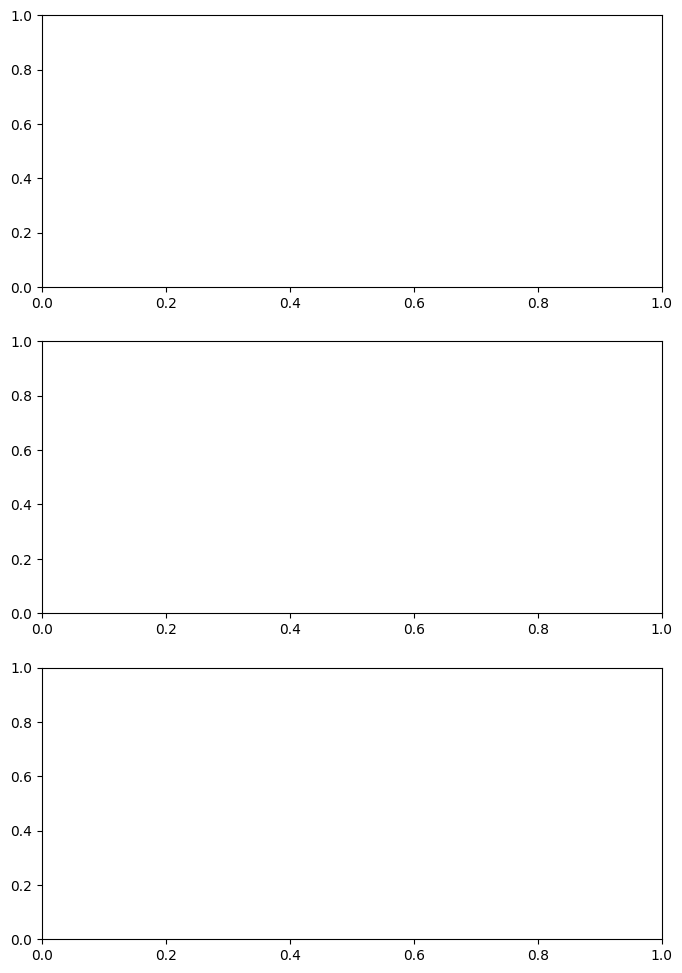

In [350]:
# @title Visualize Time Series Data
def visualize_experiment_data(data_dict):
    for k, v in data_dict.items():
        if k.find('daily_variant_level') >= 0:
            print(k)
            # Define metric groups
            metric_list_ov = ['visit', 'click', 'convert']
            metric_list_ov_fun = ['click', 'convert']
            metric_list_mc = ['monthly_convert', 'premium_monthly_convert', 'premium_plus_monthly_convert']
            metric_list_ac = ['annual_convert', 'premium_annual_convert', 'premium_plus_annual_convert']
            metric_list_ov_rate = [m + "_rate" for m in metric_list_ov_fun]
            metric_list_mc_rate = [m + "_rate" for m in metric_list_mc]
            metric_list_ac_rate = [m + "_rate" for m in metric_list_ac]

            metric_list_ov_vs_control = [m + "_relative_lift_vs_control" for m in metric_list_ov_rate]
            metric_list_mc_vs_control = [m + "_relative_lift_vs_control" for m in metric_list_mc_rate]
            metric_list_ac_vs_control = [m + "_relative_lift_vs_control" for m in metric_list_ac_rate]

            metric_lol = [
                  metric_list_ov, metric_list_mc, metric_list_ac,
                  metric_list_ov_rate,metric_list_mc_rate,metric_list_ac_rate,
                  metric_list_ov_vs_control, metric_list_mc_vs_control, metric_list_ac_vs_control
            ]

            for metric_group in metric_lol:
                # Create a single set of subplots for each metric group
                fig, axes = plt.subplots(len(metric_group), 1, figsize=(8, 12))
                palette = sns.color_palette("colorblind")

                for a, metric in enumerate(metric_group):
                    ax = axes[a]


                    # if metric is relative_lift_vs_control, then dont plot control group
                    for i, variant_name in enumerate(v['variant_name'].unique()):
                        sub_v = v[v['variant_name'] == variant_name]
                        color = palette[i % len(palette)]
                        ax.plot(sub_v['bucketed_date'], sub_v[metric], label=variant_name, color=color)

                    ax.set_xlabel('Exposure Date')
                    ax.set_ylabel('Value')
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                    ax.set_title(f'{k}: {metric}')
                    ax.legend(loc='upper right',  frameon=True, fontsize=8)


                plt.tight_layout()
                plt.show()
                metric_string = "_".join(metric_group)
                fig.savefig(f"{output_vars['experiment_name']}_{metric_string}_{k}_.png")
                plt.clf()
        else:
            pass
visualize_experiment_data(agg_lifts_dict)

In [ ]:
# @title Visualize Hypothesis Testing Data
def visualize_hyp_data(dict):
  """
  cycle through dictionary of hyp data frames
  plot p-values for each metric with significance line
  plot relative lift confidence intervals for each metric
  Note: each metric in hyp dict is expressed as a rate (normalized by visitors)
  """
  for k,v in dict.items():
    print("Visualizing", k)
    group_list = v['variant_group'].unique().tolist()
    #set up subplots
    plt.style.use('seaborn-deep')
    for id, g in enumerate(group_list):
      plt.figure(figsize = (8,8))
      #subset data frame to just 1 group
      sub_v = v[v['variant_group'] == g]
      #plot, name and save p-values
      plt.bar(sub_v['metric'], sub_v['p_value'])
      print(sub_v['metric'])
      #plot data labels
      for i, val in enumerate(sub_v['p_value']):
        plt.text(i, val, round(val,4), ha = 'center', fontsize = 8)
      plt.xticks(fontsize=9, rotation=90)
      plt.yticks(fontsize=10)
      plt.xlabel("Rate Metrics: Normalized by Visitors", size=10)
      plt.ylabel("p-value", size=10)
      plt.title("P-values for "+ output_vars['experiment_name'] + ': ' + g, size=12)
      plt.axhline(y=0.1, color='red', linestyle='dotted', label='Threshold (0.1)')  # Add the dotted line
      plt.tight_layout()
      plt.savefig(f"{output_vars['experiment_name']}_{k}_group_{g}_pvals.png")
      plt.show()
      plt.clf()

      #plot name and save confidence interval
      plt.figure(figsize = (8,8))
      def percentage_formatter(x, pos):
        return f'{x * 100:.0f}%'
      for x, lower,relative, upper in zip(range(len(sub_v)), sub_v['ci_lower_relative'],sub_v['relative_diff'], sub_v['ci_upper_relative']):
        plt.plot((x,x,x),(lower,relative,upper), 'o-',color='blue', markersize = 2)
        plt.xticks(range(len(sub_v)),list(sub_v['metric']), rotation = 90)
        plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        plt.xlabel("Rate Metrics: Normalized by Visitors", size=10)
        plt.ylabel("Relative Lift Confidence Interval", size=10)
        plt.title(str(percentage_formatter(1- hyp_test_vars['alpha'],0))+ " Confidence Intervals for "+ output_vars['experiment_name'] + ': ' + g, size=10)
        plt.axhline(y=0.0, color='red', linestyle='dotted')
      plt.tight_layout()
      plt.savefig(f"{output_vars['experiment_name']}_{k}_group_{g}_relative_lift_confidence_intervals.png")
      plt.show()
      plt.clf()
  plt.close()
  pass
#run function
visualize_hyp_data(hypothesis_dict)